In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import pickle

# Load dataset
data = pd.read_csv("diabetes_dataset.csv")
data.dropna(subset=["diabetes"], inplace=True)

# Preprocess data
X = data.drop("diabetes", axis=1)
Y = data["diabetes"].astype(int)

# Encode categorical features
label_encoder = LabelEncoder()
X["gender"] = label_encoder.fit_transform(X["gender"])
X["smoking_history"] = label_encoder.fit_transform(X["smoking_history"])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

# Define custom layer
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config

# Build model
model = Sequential([
    Input(shape=(X_pca.shape[1],)),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

# Compile and train
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Save model properly
model.save("diabetes_detector.h5")

# Save weights using 

with open("diabetes_detector.pkl", 'wb') as f:
    pickle.dump(model.get_weights(), f)

# Set up LIME explainer
explainer = LimeTabularExplainer(
    X_train, training_labels=Y_train, mode="classification",
    feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])],
    discretize_continuous=False
)

# Save scaler and PCA as pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("pca.pkl", "wb") as f:
    pickle.dump(pca, f)



Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8452 - loss: 0.3475 - val_accuracy: 0.8813 - val_loss: 0.2605
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8795 - loss: 0.2678 - val_accuracy: 0.8844 - val_loss: 0.2504
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8794 - loss: 0.2707 - val_accuracy: 0.8872 - val_loss: 0.2531
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8803 - loss: 0.2592 - val_accuracy: 0.8813 - val_loss: 0.2515
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8756 - loss: 0.2649 - val_accuracy: 0.8828 - val_loss: 0.2548
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8786 - loss: 0.2619 - val_accuracy: 0.8853 - val_loss: 0.2470
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8847 - loss: 0.2500 - val_accuracy: 0.8813 - val_loss: 0.2472
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8802 - loss: 0.2552 - val_acc

In [2]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("pca.pkl", "wb") as f:
    pickle.dump(pca, f)


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
#import gradio as gr



In [5]:
# Load and preprocess dataset
data = pd.read_csv("diabetes_dataset.csv")
data.dropna(subset=["diabetes"], inplace=True)



In [6]:
data.shape

(20000, 9)

In [7]:
# Separate features and target
X = data.drop("diabetes", axis=1)
Y = data["diabetes"].astype(int)



In [8]:
# Encode categorical features
label_encoder = LabelEncoder()
X["gender"] = label_encoder.fit_transform(X["gender"])
X["smoking_history"] = label_encoder.fit_transform(X["smoking_history"])



In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)



In [11]:
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)



In [12]:
# Build neural network with skip connections
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu"):
        super().__init__()
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])



In [13]:
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config


In [14]:
# Build a deeper neural network with skip connections
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config

model = Sequential([
    Input(shape=(X_pca.shape[1],)),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(256),
    Dropout(0.5),
    SkipDense(256),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(8, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="softmax")  # Output layer
])





In [16]:
# Compile and train the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6764 - loss: 0.6077 - val_accuracy: 0.8609 - val_loss: 0.3591
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8583 - loss: 0.3461 - val_accuracy: 0.7834 - val_loss: 0.4209
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8509 - loss: 0.3448 - val_accuracy: 0.8066 - val_loss: 0.3853
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8573 - loss: 0.3290 - val_accuracy: 0.8675 - val_loss: 0.2837
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8594 - loss: 0.3318 - val_accuracy: 0.8425 - val_loss: 0.3346
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8561 - loss: 0.3163 - val_accuracy: 0.8012 - val_loss: 0.3675
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8610 - loss: 0.3092 - val_accuracy: 0.8838 - val_loss: 0.2981
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8635 - loss: 0.3210 - val_accu

In [17]:
# Evaluate the model
accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 88.52%


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
Y_pred_probs = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1)



125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [19]:
# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=["Non-Diabetic", "Diabetic"]))



Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.88      0.92      0.90      2251
    Diabetic       0.89      0.85      0.87      1749

    accuracy                           0.89      4000
   macro avg       0.89      0.88      0.88      4000
weighted avg       0.89      0.89      0.88      4000



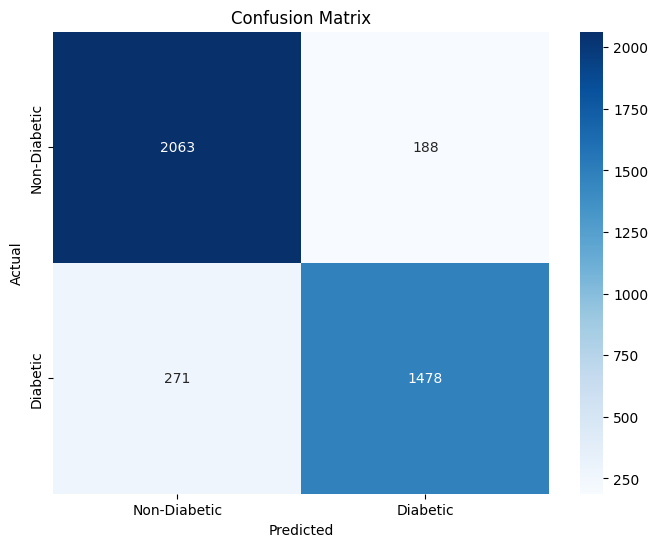

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Diabetic", "Diabetic"], yticklabels=["Non-Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [24]:
# Save the model
model.save("diabetes_detector.keras")



In [27]:
# Load the saved model
model = load_model("diabetes_detector.keras",custom_objects={'SkipDense': SkipDense})

C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'skip_dense_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'skip_dense_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `bui

In [28]:
# LIME explainer setup
explainer = LimeTabularExplainer(
    X_train, training_labels=Y_train, mode="classification", feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])]
)



In [32]:
import numpy as np
np.save("X_train.npy", X_train)
np.save("Y_train.npy", Y_train)


In [29]:
# Prediction function
def predict_diabetes(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level):
    try:
        # Map gender and smoking history
        gender_map = {"Male": 1, "Female": 0}
        smoking_map = {"Never": 0, "Current": 1, "Former": 2, "Not Current": 3, "No Info": 4, "Ever": 5}

        # Validate inputs
        gender_num = gender_map[gender]
        smoking_num = smoking_map[smoking_history]

        # Prepare input data
        input_data = np.array([[gender_num, age, hypertension, heart_disease, smoking_num, bmi, hba1c_level, blood_glucose_level]])

        # Standardize and apply PCA
        input_scaled = scaler.transform(input_data)
        input_pca = pca.transform(input_scaled)

        # Predict
        prediction = model.predict(input_pca)
        is_diabetic = np.argmax(prediction, axis=1)[0]
        probability = prediction[0][is_diabetic]

        # Generate unique precautions based on probability
        if is_diabetic:
            if probability > 0.9:
                precautions = (
                    "You are at an extremely high risk of diabetes. Immediate medical intervention is critical. "
                    "Start diabetes management under medical supervision, avoid high-sugar foods completely, "
                    "and maintain a structured physical activity routine tailored by a healthcare provider."
                )
            elif probability > 0.8:
                precautions = (
                    "You are at a very high risk of diabetes. Consult a healthcare provider immediately to explore "
                    "medication options. Adopt a strict low-glycemic diet and monitor your blood sugar levels daily."
                )
            elif probability > 0.7:
                precautions = (
                    "Your diabetes risk is high. Begin regular blood sugar monitoring and increase physical activity. "
                    "Focus on reducing refined carbs, and include lean protein sources like fish and legumes in your diet."
                )
            elif probability > 0.6:
                precautions = (
                    "You are moderately at risk of diabetes. Incorporate 30-45 minutes of aerobic exercise daily. "
                    "Reduce your intake of processed foods and sugary beverages. Consult a dietitian for meal planning."
                )
            elif probability > 0.5:
                precautions = (
                    "Your diabetes risk is moderate. Schedule a glucose tolerance test to assess your condition. "
                    "Increase your intake of whole grains and leafy greens, and avoid sedentary behavior."
                )
            elif probability > 0.4:
                precautions = (
                    "You are at a slightly elevated risk of diabetes. Focus on weight management through regular exercise "
                    "and portion control. Stay hydrated and ensure you get at least 7-8 hours of sleep per night."
                )
            elif probability > 0.3:
                precautions = (
                    "Your risk of diabetes is low to moderate. Minimize your consumption of sugary snacks, "
                    "and include stress-relieving activities like yoga or meditation to promote overall health."
                )
            elif probability > 0.2:
                precautions = (
                    "Your diabetes risk is relatively low. Continue with a balanced diet that includes a variety of vegetables, "
                    "and aim for 150 minutes of moderate exercise weekly. Have your blood glucose levels checked annually."
                )
            elif probability > 0.1:
                precautions = (
                    "You are at a minimal risk of diabetes. Maintain your current healthy habits. Avoid prolonged periods of inactivity, "
                    "and include omega-3-rich foods like nuts and seeds in your diet."
                )
            else:
                precautions = (
                    "You have an extremely low risk of diabetes. Keep up your healthy lifestyle. Stay active, eat a diverse diet, "
                    "and avoid unnecessary weight gain to maintain your current health."
                )
        else:
            precautions = (
                "You are not prone to diabetes. Maintain a healthy lifestyle, including regular physical activity, "
                "a balanced diet, and routine health check-ups to prevent any future risks."
            )

        # Perform LIME analysis
        explanation = explainer.explain_instance(input_pca[0], model.predict)
        lime_filename = "lime_analysis.html"
        explanation.save_to_file(lime_filename)

        return {
            "Prediction": "Diabetic" if is_diabetic else "Non-Diabetic",
            "Probability": f"{probability * 100:.2f}%",
            "Precautions": precautions,
            "LIME Analysis": f"LIME analysis saved to {lime_filename}. Open it in a browser to view."
        }

    except Exception as e:
        return {
            "Prediction": f"Error: {str(e)}",
            "Probability": "Error",
            "Precautions": "Error",
            "LIME Analysis": "Error"
        }



In [33]:
# Prediction function
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

#Architecture
# Build a deeper neural network with skip connections
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config

model = Sequential([
    Input(shape=(X_pca.shape[1],)),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(256),
    Dropout(0.5),
    SkipDense(256),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(8, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="softmax")  # Output layer
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Load the saved model
model = load_model("diabetes_detector.keras",custom_objects={'SkipDense': SkipDense})

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Load the PCA
with open("pca.pkl", "rb") as f:
    pca = pickle.load(f)

X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")

explainer = LimeTabularExplainer(
    X_train,
    training_labels=Y_train,
    mode="classification",
    feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])]
)


def predict_diabetes(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level):
    try:
        # Map gender and smoking history
        gender_map = {"Male": 1, "Female": 0}
        smoking_map = {"Never": 0, "Current": 1, "Former": 2, "Not Current": 3, "No Info": 4, "Ever": 5}

        # Validate inputs
        gender_num = gender_map[gender]
        smoking_num = smoking_map[smoking_history]

        # Prepare input data
        input_data = np.array([[gender_num, age, hypertension, heart_disease, smoking_num, bmi, hba1c_level, blood_glucose_level]])

        # Standardize and apply PCA
        input_scaled = scaler.transform(input_data)
        input_pca = pca.transform(input_scaled)
        print("X_pca.shape[1]: ",input_pca.shape[1])
        # Predict
        prediction = model.predict(input_pca)
        is_diabetic = np.argmax(prediction, axis=1)[0]
        probability = prediction[0][is_diabetic]

        # Generate unique precautions based on probability
        if is_diabetic:
            if probability > 0.9:
                precautions = (
                    "You are at an extremely high risk of diabetes. Immediate medical intervention is critical. "
                    "Start diabetes management under medical supervision, avoid high-sugar foods completely, "
                    "and maintain a structured physical activity routine tailored by a healthcare provider."
                )
            elif probability > 0.8:
                precautions = (
                    "You are at a very high risk of diabetes. Consult a healthcare provider immediately to explore "
                    "medication options. Adopt a strict low-glycemic diet and monitor your blood sugar levels daily."
                )
            elif probability > 0.7:
                precautions = (
                    "Your diabetes risk is high. Begin regular blood sugar monitoring and increase physical activity. "
                    "Focus on reducing refined carbs, and include lean protein sources like fish and legumes in your diet."
                )
            elif probability > 0.6:
                precautions = (
                    "You are moderately at risk of diabetes. Incorporate 30-45 minutes of aerobic exercise daily. "
                    "Reduce your intake of processed foods and sugary beverages. Consult a dietitian for meal planning."
                )
            elif probability > 0.5:
                precautions = (
                    "Your diabetes risk is moderate. Schedule a glucose tolerance test to assess your condition. "
                    "Increase your intake of whole grains and leafy greens, and avoid sedentary behavior."
                )
            elif probability > 0.4:
                precautions = (
                    "You are at a slightly elevated risk of diabetes. Focus on weight management through regular exercise "
                    "and portion control. Stay hydrated and ensure you get at least 7-8 hours of sleep per night."
                )
            elif probability > 0.3:
                precautions = (
                    "Your risk of diabetes is low to moderate. Minimize your consumption of sugary snacks, "
                    "and include stress-relieving activities like yoga or meditation to promote overall health."
                )
            elif probability > 0.2:
                precautions = (
                    "Your diabetes risk is relatively low. Continue with a balanced diet that includes a variety of vegetables, "
                    "and aim for 150 minutes of moderate exercise weekly. Have your blood glucose levels checked annually."
                )
            elif probability > 0.1:
                precautions = (
                    "You are at a minimal risk of diabetes. Maintain your current healthy habits. Avoid prolonged periods of inactivity, "
                    "and include omega-3-rich foods like nuts and seeds in your diet."
                )
            else:
                precautions = (
                    "You have an extremely low risk of diabetes. Keep up your healthy lifestyle. Stay active, eat a diverse diet, "
                    "and avoid unnecessary weight gain to maintain your current health."
                )
        else:
            precautions = (
                "You are not prone to diabetes. Maintain a healthy lifestyle, including regular physical activity, "
                "a balanced diet, and routine health check-ups to prevent any future risks."
            )

        # Perform LIME analysis
        explanation = explainer.explain_instance(input_pca[0], model.predict)
        lime_filename = "lime_analysis.html"
        explanation.save_to_file(lime_filename)

        return {
            "Prediction": "Diabetic" if is_diabetic else "Non-Diabetic",
            "Probability": f"{probability * 100:.2f}%",
            "Precautions": precautions,
            "LIME Analysis": f"LIME analysis saved to {lime_filename}. Open it in a browser to view."
        }

    except Exception as e:
        return {
            "Prediction": f"Error: {str(e)}",
            "Probability": "Error",
            "Precautions": "Error",
            "LIME Analysis": "Error"
        }
def test_predict_diabetes():
    result = predict_diabetes("Male", 45, 0, 0, "Never", 25.0, 5.5, 90)
    print("Test Result:")
    print(result)

# Run the test
test_predict_diabetes()

C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'skip_dense_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'skip_dense_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:391: UserWarning: `bui

X_pca.shape[1]:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

C:\Users\lenin\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\lenin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Result:
{'Prediction': 'Non-Diabetic', 'Probability': '90.40%', 'Precautions': 'You are not prone to diabetes. Maintain a healthy lifestyle, including regular physical activity, a balanced diet, and routine health check-ups to prevent any future risks.', 'LIME Analysis': 'LIME analysis saved to lime_analysis.html. Open it in a browser to view.'}


In [ ]:
# Gradio interface
def gradio_interface(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level):
    result = predict_diabetes(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level)
    return result["Prediction"], result["Probability"], result["Precautions"], result["LIME Analysis"]

interface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Radio(["Male", "Female"], label="Gender"),
        gr.Slider(0, 120, step=1, label="Age"),
        gr.Radio([0, 1], label="Hypertension (0: No, 1: Yes)"),
        gr.Radio([0, 1], label="Heart Disease (0: No, 1: Yes)"),
        gr.Dropdown(["Never", "Current", "Former", "Not Current", "No Info", "Ever"], label="Smoking History"),
        gr.Slider(10, 50, step=0.1, label="BMI"),
        gr.Slider(4.0, 15.0, step=0.1, label="HbA1c Level"),
        gr.Slider(50, 300, step=1, label="Blood Glucose Level")
    ],
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Probability"),
        gr.Textbox(label="Precautions"),
        gr.Textbox(label="LIME Analysis")
    ],
    title="Diabetes Prediction",
    description="Enter the details below to predict if a person is diabetic and view precautions.",
    theme="default",
    live=False
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/28 16:14:05 [W] [service.go:132] login to server failed: dial tcp: lookup gradio-live.com: i/o timeout
